## 1. Import Libaries

In [1]:
# use this code to download data if necessary
# import kagglehub
#prashantarorat_facial_key_point_data_path = kagglehub.dataset_download('prashantarorat/facial-key-point-data')
#print('Data source import complete.')
#print(prashantarorat_facial_key_point_data_path)


In [2]:
import os
import json
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Tuple
import jax
import jax.numpy as jnp
from jax import random, jit, value_and_grad
from flax.core import freeze, unfreeze
import flax.linen as nn
import optax
import matplotlib.pyplot as plt

## 2. Data Utilities

In [3]:
def load_images(src: str, files: list, color_mode: str = 'gray') -> np.ndarray:
    if not os.path.isdir(src):
        raise FileNotFoundError(f"Source directory '{src}' not found.")
    imgs = []
    for file in files:
        path = os.path.join(src, file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE if color_mode=='gray' else cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Image '{path}' not found.")
        img = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0
        if color_mode == 'gray':
            img = img[..., None]
        imgs.append(img)
    return np.stack(imgs)


def load_data(images_dir: str, json_file: str,
              test_size: float = 0.2, seed: int = 42) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, float, float]:
    with open(json_file, 'r') as f:
        data = json.load(f)
    files, key_pts = [], []
    for v in data.values():
        files.append(v['file_name'])
        key_pts.append(np.array(v['face_landmarks'], dtype=np.float32).reshape(-1))
    key_pts = np.stack(key_pts)
    train_files, test_files, train_pts, test_pts = train_test_split(
        files, key_pts, test_size=test_size, random_state=seed, shuffle=True
    )
    X_train = load_images(images_dir, train_files, 'gray')
    X_test  = load_images(images_dir, test_files,  'gray')
    mean = train_pts.mean()
    std  = train_pts.std()
    y_train = ((train_pts - mean) / std).astype(np.float32)
    y_test  = ((test_pts  - mean) / std).astype(np.float32)
    return X_train, X_test, y_train, y_test, mean, std

## 3. Model Definition


In [4]:
class KeypointCNN(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True) -> jnp.ndarray:
        # … your layers …
        return x

    @nn.compact
    def __call__(self, x, train: bool = True) -> jnp.ndarray:
        for filters, kernel in [(32,5),(64,3),(128,3),(256,3),(256,3)]:
            x = nn.Conv(filters, (kernel, kernel))(x)
            x = nn.relu(x)
            x = nn.max_pool(x, (2,2), (2,2))
            x = nn.Dropout(0.3)(x, deterministic=not train)
        x = x.reshape((x.shape[0], -1))
        for units in [1024, 512, 256]:
            x = nn.Dense(units)(x)
            x = nn.relu(x)
        x = nn.Dense(136)(x)
        return x

## 4. Training & Evaluation Functions

In [5]:
from functools import partial

@partial(jit, static_argnums=(4,5))
def train_step(params, opt_state, batch_x, batch_y, model, optimizer, rng):
    rng, dropout_rng = random.split(rng)
    def loss_fn(p):
        preds = model.apply({'params': p}, batch_x, train=True, rngs={'dropout': dropout_rng})
        return jnp.mean((preds - batch_y) ** 2)
    loss, grads = value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, rng

@partial(jit, static_argnums=(3,))
def eval_step(params, batch_x, batch_y, model):
    preds = model.apply({'params': params}, batch_x, train=False)
    return jnp.mean((preds - batch_y) ** 2)

@jit
def mse_loss(preds, targets):
    return jnp.mean((preds - targets) ** 2)


def create_train_state(rng, lr: float):
    model = KeypointCNN()
    rng, init_rng = random.split(rng)
    variables = model.init({'params': init_rng, 'dropout': init_rng}, jnp.ones([1,224,224,1]), train=True)
    params = variables['params']
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    return model, params, optimizer, opt_state, rng


## 5. Prediction Utility

In [6]:
def predict_image(params, model, image_path: str, mean: float, std: float) -> np.ndarray:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224)).astype(np.float32) / 255.0
    img = img[None, ..., None]
    preds = model.apply({'params': params}, jnp.array(img), train=False)
    preds = np.array(preds.squeeze()) * std + mean
    return preds.reshape(-1,2)

## 6. Main Training

2025-05-14 20:55:01.599921: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-14 20:55:01.601816: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-14 20:55:01.601866: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-14 20:55:01.601902: W external/tsl/tsl/framework/bfc_allocator.cc:296] Alloca

Epoch 1/50 - train_loss: 0.427740, test_loss: 0.508822
Epoch 2/50 - train_loss: 0.066729, test_loss: 0.298186
Epoch 3/50 - train_loss: 0.051816, test_loss: 0.161124
Epoch 4/50 - train_loss: 0.049255, test_loss: 0.101820
Epoch 5/50 - train_loss: 0.048609, test_loss: 0.082672
Epoch 6/50 - train_loss: 0.048297, test_loss: 0.076470
Epoch 7/50 - train_loss: 0.048964, test_loss: 0.064656
Epoch 8/50 - train_loss: 0.047992, test_loss: 0.051366
Epoch 9/50 - train_loss: 0.047589, test_loss: 0.053815
Epoch 10/50 - train_loss: 0.047263, test_loss: 0.050179
Epoch 11/50 - train_loss: 0.046741, test_loss: 0.048225
Epoch 12/50 - train_loss: 0.046222, test_loss: 0.051948
Epoch 13/50 - train_loss: 0.045447, test_loss: 0.052623
Epoch 14/50 - train_loss: 0.045160, test_loss: 0.053155
Epoch 15/50 - train_loss: 0.043418, test_loss: 0.047021
Epoch 16/50 - train_loss: 0.039259, test_loss: 0.043718
Epoch 17/50 - train_loss: 0.036113, test_loss: 0.040828
Epoch 18/50 - train_loss: 0.034599, test_loss: 0.047266
E

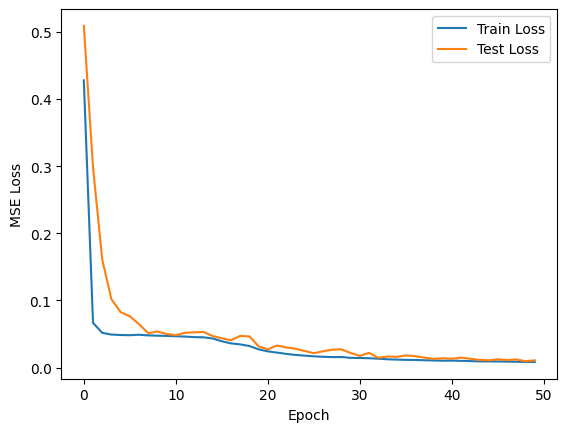

In [7]:
def main():
    images_dir = "/users/cwu101/data/cwu101/Facial-Keypoint-Detection/CNN/images"
    json_file  = "/users/cwu101/data/cwu101/Facial-Keypoint-Detection/CNN/all_data.json"
    X_train, X_test, y_train, y_test, mean, std = load_data(images_dir, json_file)

    rng = random.PRNGKey(0)
    model, params, optimizer, opt_state, rng = create_train_state(rng, 1e-3)

    epochs, batch_size = 50, 128
    train_losses, test_losses = [], []
    num_train = X_train.shape[0]

    for epoch in range(1, epochs+1):
        perm = np.random.permutation(num_train)
        X_train, y_train = X_train[perm], y_train[perm]
        batch_losses = []
        for i in range(num_train // batch_size):
            bx = X_train[i*batch_size:(i+1)*batch_size]
            by = y_train[i*batch_size:(i+1)*batch_size]
            params, opt_state, loss, rng = train_step(params, opt_state, bx, by, model, optimizer, rng)
            batch_losses.append(loss)
        train_loss = np.mean(batch_losses)
        test_loss  = eval_step(params, X_test, y_test, model)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch {epoch}/{epochs} - train_loss: {train_loss:.6f}, test_loss: {test_loss:.6f}")

    os.makedirs("./jax_keypoints_params", exist_ok=True)
    with open("./jax_keypoints_params/params.npy","wb") as f:
        np.save(f, params)

    import matplotlib.pyplot as plt
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

## 7. Evaluation of the model on test dataset

In [8]:
images_dir = "/users/cwu101/data/cwu101/Facial-Keypoint-Detection/CNN/images"
json_file  = "/users/cwu101/data/cwu101/Facial-Keypoint-Detection/CNN/all_data.json"

In [9]:
X_train, X_test, y_train, y_test, mean, std = load_data(images_dir, json_file)

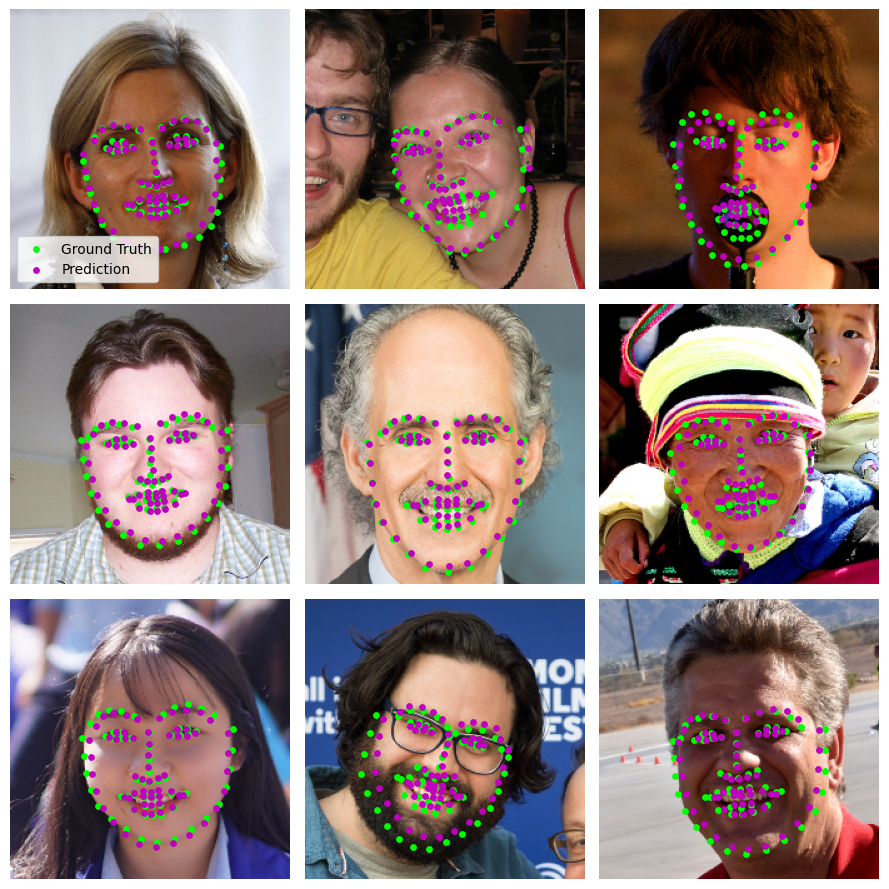

In [10]:
params_path = "./jax_keypoints_params/params.npy"
num_samples = 9
new_size = (224, 224)

with open(json_file, 'r') as f:
    data = json.load(f)

model = KeypointCNN()
params = np.load(params_path, allow_pickle=True).item()

keys = list(data.keys())
chosen = np.random.choice(keys, size=num_samples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for ax, key in zip(axes.ravel(), chosen):
    entry = data[key]
    fname = entry['file_name']
    lm = np.array(entry['face_landmarks'], dtype=np.float32)

    img_path = os.path.join(images_dir, fname)
    orig = cv2.imread(img_path)
    if orig is None:
        raise FileNotFoundError(f"Could not load {img_path}")
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = orig.shape[:2]

    scale_x = new_size[0] / orig_w
    scale_y = new_size[1] / orig_h

    img_resized = cv2.resize(orig, new_size)
    ax.imshow(img_resized)
    ax.axis('off')

    gt_scaled = np.stack([lm[:, 0] * scale_x, lm[:, 1] * scale_y], axis=1)
    ax.scatter(gt_scaled[:, 0], gt_scaled[:, 1], c='lime', s=15, label='Ground Truth')

    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
    input_img = gray[None, ..., None]

    pred_norm = model.apply({'params': params}, jnp.array(input_img), train=False)
    pred = np.array(pred_norm.squeeze()) * std + mean  # shape (136,)
    pred_pts = pred.reshape(-1, 2)

    pred_scaled = np.stack([pred_pts[:, 0] * scale_x, pred_pts[:, 1] * scale_y], axis=1)
    ax.scatter(pred_scaled[:, 0], pred_scaled[:, 1], c='m', s=15, label='Prediction')

axes[0, 0].legend(loc='lower left')
plt.tight_layout()
plt.show()
